In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv('Sentiment_analysis_dataset.csv')

print(f'Total number of rows: {len(df)}')

print(f'Number of rows containing null values: {df.isnull().any(axis=1).sum()}')
df.head()

Total number of rows: 37130
Number of rows containing null values: 254


,Statement,Status
0,life doesn’t feel worth it that’s kind of it? ...,Depression
1,This life sucks and if it were for my religiou...,Depression
2,its been 9 months now for our marriage and she...,Stress
3,I do not feel particularly sad or anxious or a...,Depression
4,I am taking Venlafaxine. it is an SSRI. does n...,Depression


Number of duplicate rows: 796
Status
Normal                  176
Depression              148
Bipolar                 140
Stress                  129
Anxiety                 105
Personality disorder     94
Suicidal                  4
Name: count, dtype: int64


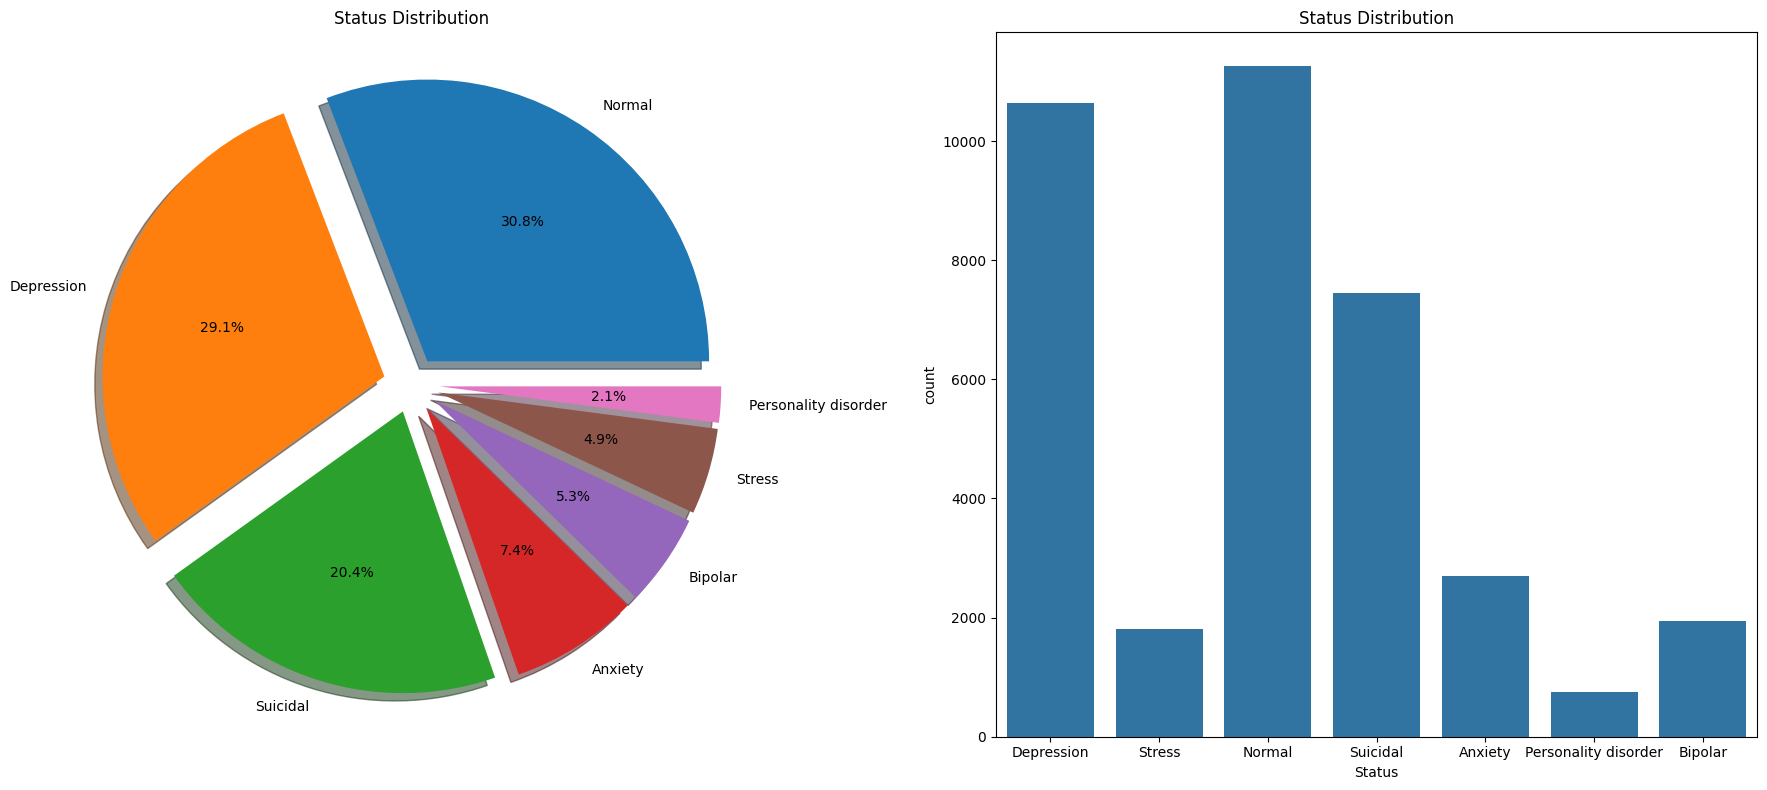

In [8]:
df = df.dropna(subset=['Statement', 'Status'])

duplicate_count = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

# Identify duplicate rows
duplicate_rows = df[df.duplicated()]

print(duplicate_rows['Status'].value_counts())

# Filter the duplicate rows where the status is "Normal" or "Depression"
duplicate_to_drop = duplicate_rows[duplicate_rows['Status'].isin(['Normal', 'Depression'])]

# Drop those specific rows
df = df.drop(duplicate_to_drop.index)

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot pie chart of the target variable with sorted values
df['Status'].value_counts().sort_values(ascending=False).plot.pie(explode=[0.1] * len(df['Status'].value_counts()), autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Status Distribution')
ax[0].set_ylabel('')

# Plot countplot for the target variable
sns.countplot(x='Status', data=df, ax=ax[1])
ax[1].set_title('Status Distribution')

# Show the plot
plt.tight_layout()  # To ensure that the subplots don't overlap
plt.show()

In [9]:
#Data augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df.apply(lambda row: augment_text(row['Statement'])
                                     if row['Status'] in ['Anxiety', 'Stress','Bipolar','Personality disorder'] else None, axis=1)
translated_rows = df[df['augmented_statement'].notna()]
translated_rows['Statement'] = translated_rows['augmented_statement']

# Step 4: Add only the translated rows back to the original dataframe
df = pd.concat([df, translated_rows[['Statement', 'Status']]])

# Optionally, drop the 'augmented_statement' column if you no longer need it
df = df.drop(columns=['augmented_statement'])

C:\Users\User\AppData\Local\Temp\ipykernel_19088\2028483662.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  translated_rows['Statement'] = translated_rows['augmented_statement']


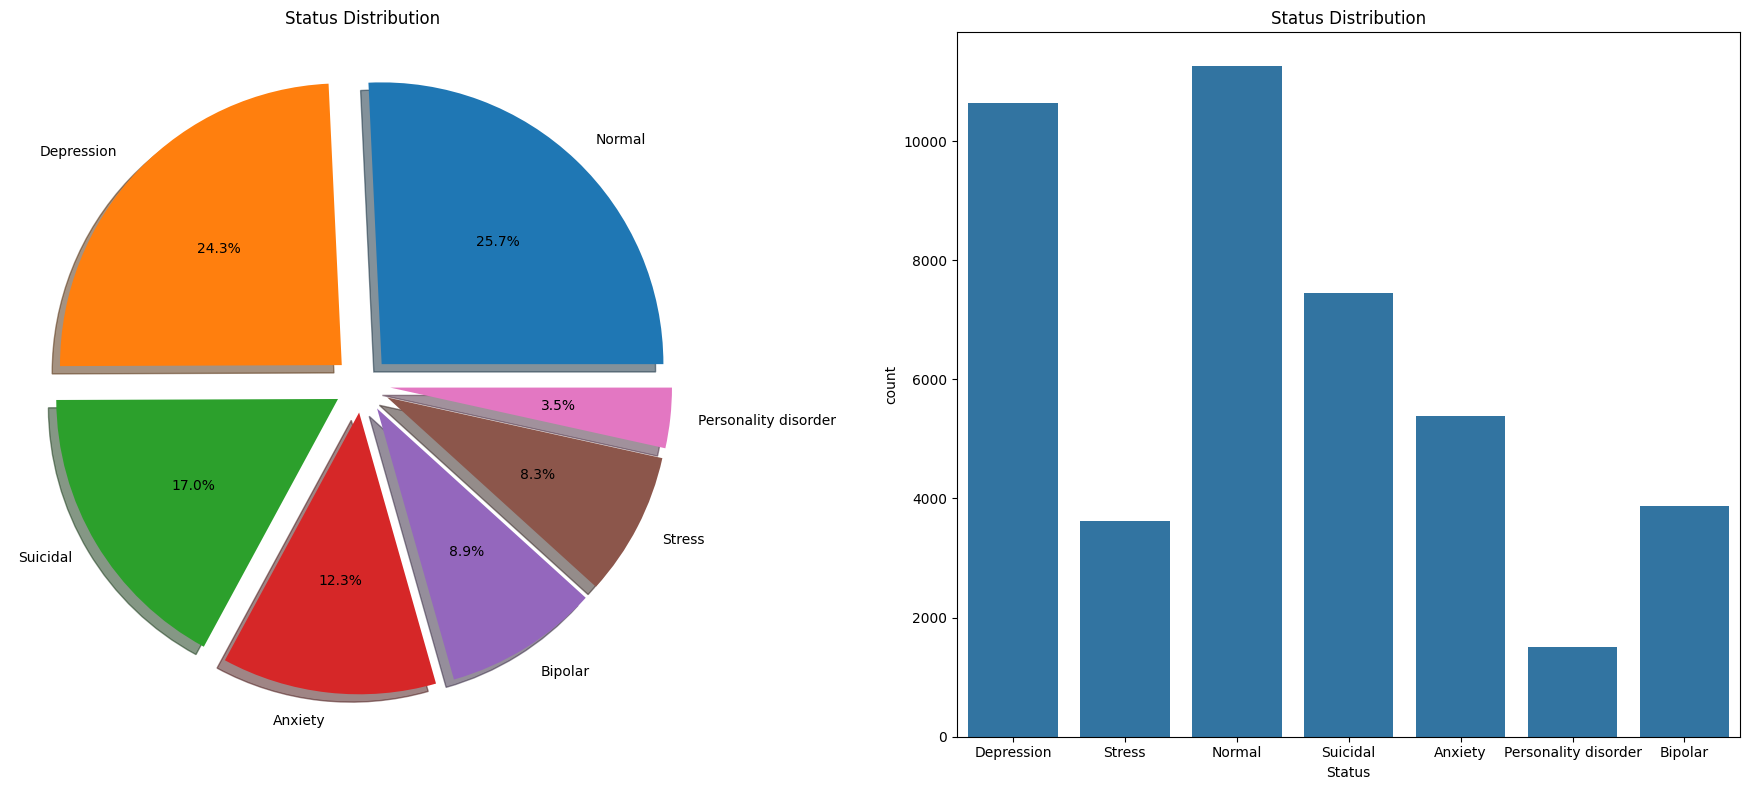

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot pie chart of the target variable with sorted values
df['Status'].value_counts().sort_values(ascending=False).plot.pie(explode=[0.1] * len(df['Status'].value_counts()), autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Status Distribution')
ax[0].set_ylabel('')

# Plot countplot for the target variable
sns.countplot(x='Status', data=df, ax=ax[1])
ax[1].set_title('Status Distribution')

# Show the plot
plt.tight_layout()  # To ensure that the subplots don't overlap
plt.show()

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_stem(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Statement'] = df['Statement'].apply(lambda x: preprocess_text(x))
df['Statement'] = df['Statement'].apply(lambda x: remove_stopwords_and_stem(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [12]:
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

In [13]:
df.head()

,Statement,Status
0,life ’ feel worth ’ kind ’ made lot discoveri ...,2
1,life suck religi belief suicid send hell would...,2
2,month marriag manag sleep light cant even thin...,5
3,feel particularli sad anxiou anyth feel like w...,2
4,take venlafaxin ssri cure depress certainli ta...,2


In [14]:
X = df['Statement']
y = df['Status']

In [18]:
vectorizer = TfidfVectorizer(
    max_features=5000,            # increase to 30k
    ngram_range=(1, 3),            # use unigrams, bigrams, trigrams
    stop_words='english',
    min_df=5,                      # remove very rare words
    max_df=0.9                     # remove overly common words
)

#TF-IDF Vectorization approach: good for xgboost, Logistic Regression, Naive Bayes, SVM
# will use the original set and change the class weights when training the models
X_tfidf = vectorizer.fit_transform(X).toarray()

In [19]:
#Tokenization and Padding Approach: good for deep learning models like RNNs, LSTMs, CNNs
# will use the original set and change the class weights when training the models
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=100)

In [20]:
# will use the smote technique to create synthetic samples by interpolating between examples in the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_tfidf_smote, y_tfidf_smote = smote.fit_resample(X_tfidf, y)
X_smote_padded, y_smote_padded = smote.fit_resample(X_padded, y)